# Урок 3. Построение надежных схем валидации решения, оптимизация целевых метрик

**Основное задание:**
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов \- **ROC-AUC**, название целевой переменной \- **IsFraud**. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые. **Внимание!** выборка `assignment_2_test.csv` \- наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. **Для других целей использовать выборку запрещено!**.
​
**Терминалогия, используемая в задании:**
\* обучающая выборка \- выборка, которая передается в метод `fit` / `train`;
\* валидационная выборка \- выборка, которая получается при Hold-Out на 2 выборки (`train`, `valid`);
\* тестовая выборка \- выборка, которая получается при Hold-Out на 3 выборки (`train`, `valid`, `test`);
\* ЛБ \- лидерборд, выборка `assignment_2_test.csv`.
​
**Задание 1:** сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (`TransactionID`), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.
​
**Задание 2:** сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.
​
**Задание 3:** построить доверительный интервал на данных из п.2 на основе **бутстреп** выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.
​
**Задание 4:** выполнить `Adversarial Validation`, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из `assignment_2_test.csv`, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.
​
**Задание 5:** сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.
​
**Задание 6** (опциональное): сделать Hold-Out валидацию по времени (`TransactionDT`), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.
​
**Задание 7** (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (`TransactionID`) и время транзакции (`TransactionDT`), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (`GroupKFold`).

In [176]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

import seaborn as sns
import scipy.stats as st

import warnings
warnings.simplefilter("ignore")

import warnings
from tqdm import tqdm
from typing import List, Tuple

from scipy.stats import ttest_rel

# from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

warnings.simplefilter("ignore")
%matplotlib inline

https://www.kaggle.com/jtrotman/ieee-fraud-adversarial-lgb-split-points
https://dyakonov.org/2019/03/22/%D0%BF%D0%BE%D0%B4%D0%BC%D0%B5%D0%BD%D0%B0-%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8-%D0%B2-ml/
https://towardsdatascience.com/adversarial-validation-ca69303543cd
https://github.com/zjost/blog_code/blob/master/adversarial_validation/adversarial-validation-example.ipynb

In [109]:
public_df = pd.read_csv('../assignment2_data/assignment_2_train.csv')
private_df = pd.read_csv('../assignment2_data/assignment_2_test.csv')

In [110]:
print("public_df.shape = {} rows, {} cols".format(*public_df.shape))
print("private_df.shape = {} rows, {} cols".format(*private_df.shape))

public_df.shape = 180000 rows, 394 cols
private_df.shape = 100001 rows, 394 cols


In [111]:
public_df.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
len(public_df['TransactionID'].value_counts())

180000

In [113]:
public_df[['TransactionID','isFraud','TransactionDT','TransactionAmt','addr1','addr2']]

,TransactionID,isFraud,TransactionDT,TransactionAmt,addr1,addr2
0,2987000,0,86400,68.50,315.0,87.0
1,2987001,0,86401,29.00,325.0,87.0
2,2987002,0,86469,59.00,330.0,87.0
3,2987003,0,86499,50.00,476.0,87.0
4,2987004,0,86506,50.00,420.0,87.0
...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,272.0,87.0
179996,3166996,0,3958237,59.95,315.0,87.0
179997,3166997,0,3958241,34.00,330.0,87.0
179998,3166998,0,3958260,59.00,272.0,87.0


## Задание 1.

Cделать Hold-Out валидацию с разбиением, размер которого будет
 адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID),
 обучать модель градиетного бустинга любой реализации с подбором числа деревьев
 по `early_stopping` критерию до достижения сходимости. Оценить качество модели на 
 валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке
 и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации.
 Сделать выводы.

In [114]:
# Разделим выборки на тренировчную, тестовую и валидационную.

x_train, x_test = train_test_split(public_df.drop(["TransactionID", "isFraud"], axis=1), train_size=0.60, shuffle=False, random_state=1,)
y_train, y_test = train_test_split(public_df["isFraud"], train_size=0.60, shuffle=False, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

In [115]:
x_lb = private_df.drop(["TransactionID", "isFraud"], axis=1)
y_lb = private_df["isFraud"]

In [116]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 392 cols
x_test.shape = 72000 rows, 392 cols


In [117]:
# Получим список катероиальных и числовых признаков.

categorical = []
numerical = []
for col, value in x_train.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
    else:
        numerical.append(col)

In [118]:
x_train[categorical].head(5)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
# Выделим числовые и категриальные переменные. 

x_train[categorical]=x_train[categorical].astype('category')
x_test[categorical]=x_test[categorical].astype('category')
x_lb[categorical]=x_lb[categorical].astype('category')

In [120]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    # "objective": "binary:logistic",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 50,
    "max_depth": 4,
    # "gamma": 4,
    # "nthread": 6,
    # "seed": 27,
    'random_state':1    
}

In [121]:
model = lgb.LGBMClassifier(**params)

model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    early_stopping_rounds=25,
    categorical_feature=categorical,
    # num_boost_round=10000,
    eval_metric="auc",
    verbose=20
)

[20]	training's auc: 0.891467	valid_1's auc: 0.865487
[40]	training's auc: 0.905077	valid_1's auc: 0.872462
[60]	training's auc: 0.91297	valid_1's auc: 0.876831
[80]	training's auc: 0.918017	valid_1's auc: 0.878539
[100]	training's auc: 0.922365	valid_1's auc: 0.879982
[120]	training's auc: 0.92593	valid_1's auc: 0.881412
[140]	training's auc: 0.928891	valid_1's auc: 0.882232
[160]	training's auc: 0.931409	valid_1's auc: 0.882384
[180]	training's auc: 0.933828	valid_1's auc: 0.88311
[200]	training's auc: 0.936206	valid_1's auc: 0.88377
[220]	training's auc: 0.938346	valid_1's auc: 0.884216
[240]	training's auc: 0.939944	valid_1's auc: 0.884515
[260]	training's auc: 0.94187	valid_1's auc: 0.884608
[280]	training's auc: 0.943547	valid_1's auc: 0.884749
[300]	training's auc: 0.944788	valid_1's auc: 0.88496
[320]	training's auc: 0.945909	valid_1's auc: 0.884744


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

In [122]:
# недообучение - 5
# переобучение +
# все ок = 2

In [123]:
def draw_roc_auc(model, dtrain, dvalid, y_train, y_valid):
    #  тест   
    try:
        y_pred_train = model.predict_proba(dtrain)[:,1]      
    except:
        y_pred_train = model.predict(dtrain)
    roc_auc_train=roc_auc_score(y_train, y_pred_train)
    # print(roc_auc_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_pred_train)

    try:
        y_pred_val = model.predict_proba(dvalid)[:,1]      
    except:
        y_pred_val = model.predict(dvalid)
    roc_auc_val=roc_auc_score(y_valid, y_pred_val)
    # print(roc_auc_val)
    fpr_val, tpr_val, _ = metrics.roc_curve(y_valid, y_pred_val)

    plt.plot(fpr_train, tpr_train, 'b',color="blue", label = 'train_auc = %0.2f' % roc_auc_train)
    plt.plot(fpr_val, tpr_val, 'b', color="orange", label = 'val_auc = %0.2f' % roc_auc_val)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [124]:
train_score =  roc_auc_score(y_train, model.predict(x_train))
test_score = roc_auc_score(y_test, model.predict(x_test))
lb_score = roc_auc_score(y_lb, model.predict(x_lb))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}, Lb-score: {round(lb_score, 3)} ")

Train-score: 0.722, Test-score: 0.642, Lb-score: 0.607 


## Выводы.

Качество на тестовой выборке значительно выше чем на валидационной выборке и ЛБ. 
Это означает, что распределение на этих выборках немного отличаются друг от друга.

Далее, попробуем определеить признаки по которым эти выборки отличаются. 

## Задание 2.

Cделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [125]:
x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=False, random_state=1,)
y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=False, random_state=1,)

In [126]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_val.shape = {} rows, {} cols".format(*x_val.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 392 cols
x_val.shape = 36000 rows, 392 cols
x_test.shape = 36000 rows, 392 cols


In [127]:
model = lgb.LGBMClassifier(**params)

model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_val, y_val), (x_val, y_val)],
    early_stopping_rounds=50,
    categorical_feature=categorical,
    # num_boost_round=10000,
    eval_metric="auc",
    verbose=20
)

[20]	valid_0's auc: 0.859651	valid_1's auc: 0.859651
[40]	valid_0's auc: 0.865949	valid_1's auc: 0.865949
[60]	valid_0's auc: 0.8706	valid_1's auc: 0.8706
[80]	valid_0's auc: 0.871479	valid_1's auc: 0.871479
[100]	valid_0's auc: 0.872493	valid_1's auc: 0.872493
[120]	valid_0's auc: 0.873055	valid_1's auc: 0.873055
[140]	valid_0's auc: 0.873847	valid_1's auc: 0.873847
[160]	valid_0's auc: 0.873269	valid_1's auc: 0.873269
[180]	valid_0's auc: 0.87396	valid_1's auc: 0.87396
[200]	valid_0's auc: 0.874522	valid_1's auc: 0.874522
[220]	valid_0's auc: 0.875116	valid_1's auc: 0.875116
[240]	valid_0's auc: 0.875126	valid_1's auc: 0.875126
[260]	valid_0's auc: 0.874849	valid_1's auc: 0.874849


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

In [128]:
train_score =  roc_auc_score(y_train, model.predict(x_train))
val_score = roc_auc_score(y_val, model.predict(x_val))
test_score = roc_auc_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.711, Val-score: 0.637, Test-score: 0.64


In [129]:
train_score =  roc_auc_score(y_train, model.predict_proba(x_train)[:,1])
val_score = roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
test_score = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

print(f"Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.939, Val-score: 0.876, Test-score: 0.894


## Задание 3.

Построить доверительный интервал на данных из п.2 на основе **бутстреп** выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [130]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [131]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict(x_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.626540475331432, 0.6536258302778334)

Text(0.5, 0, 'sampel number')

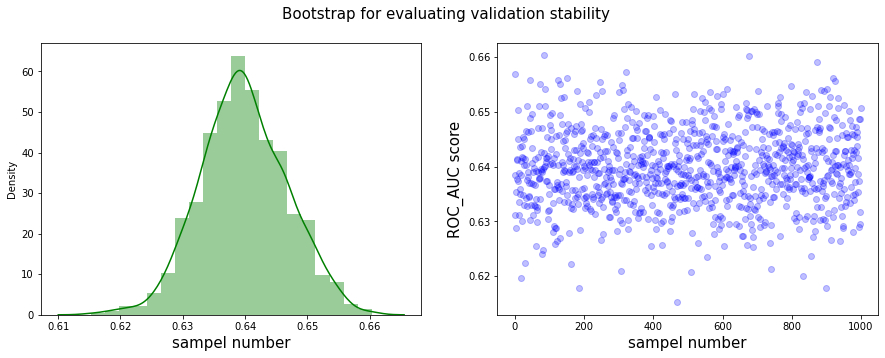

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("ROC_AUC score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

Модель показывает достаточно очень небольшой разброс на разных bootstrep выборках.
Наверное это хороший знак. зачения в распеделениы достаточно равномерно.

In [133]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_lb, model.predict(x_lb), roc_auc_score)

calculate_confidence_interval(scores)

(0.5984542241066817, 0.6109550783467368)

Text(0.5, 0, 'sampel number')

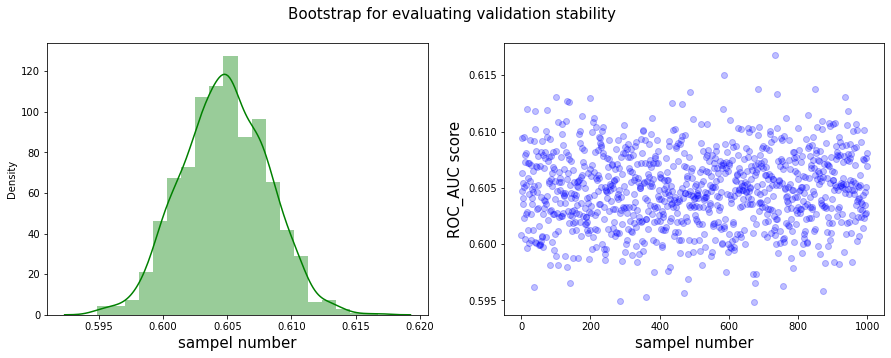

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("ROC_AUC score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

Видно, что ROC_AUC на ЛБ немного смещено вниз, по сравнению с распределнием на тестовой выборке.

## Задание 4. 

Выполнить `Adversarial Validation`, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из `assignment_2_test.csv`, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [135]:
X_adv = pd.concat([ public_df, private_df])
y_adv = np.hstack((np.ones(public_df.shape[0]), np.zeros(private_df.shape[0]))) # заполняем чать нулями, а часть 1-ми.

X_adv = X_adv.reset_index(drop=True)

In [136]:
X_adv[categorical]=X_adv[categorical].astype('category')

In [137]:
y_adv

array([1., 1., 1., ..., 0., 0., 0.])

In [138]:
X_adv

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279996,3386996,0,10091528,368.990,W,13964,496.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279997,3386997,0,10091533,445.330,W,10616,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279998,3386998,0,10091544,15.226,C,9803,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279999,3386999,0,10091549,34.742,C,16062,500.0,185.0,mastercard,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    # "objective": "binary:logistic",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 500,
    "reg_lambda": 50,
    "max_depth": 4,
    # "gamma": 4,
    # "nthread": 6,
    # "seed": 27,
    'random_state':1    
}

In [140]:
model = lgb.LGBMClassifier(**params)

In [141]:
model.fit(
    X=X_adv,
    y=y_adv,
    eval_set=[(X_adv, y_adv)],
    early_stopping_rounds=5,
    categorical_feature=categorical,
    eval_metric="auc",
    verbose=20
)

[20]	training's auc: 0.999994
[40]	training's auc: 0.999995
[60]	training's auc: 0.999996
[80]	training's auc: 0.999997
[100]	training's auc: 0.999997
[120]	training's auc: 0.999997
[140]	training's auc: 0.999998
[160]	training's auc: 0.999998
[180]	training's auc: 0.999998
[200]	training's auc: 0.999998
[220]	training's auc: 0.999999
[240]	training's auc: 0.999999
[260]	training's auc: 0.999999
[280]	training's auc: 0.999999
[300]	training's auc: 0.999999
[320]	training's auc: 0.999999
[340]	training's auc: 0.999999
[360]	training's auc: 0.999999
[380]	training's auc: 0.999999
[400]	training's auc: 0.999999
[420]	training's auc: 1
[440]	training's auc: 1
[460]	training's auc: 1
[480]	training's auc: 1
[500]	training's auc: 1


LGBMClassifier(max_depth=4, metric='auc', n_estimators=500, objective='binary',
               random_state=1, reg_lambda=50)

In [142]:
%%time
cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)
print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 1.0
CPU times: user 7min 38s, sys: 3.91 s, total: 7min 42s
Wall time: 1min 14s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

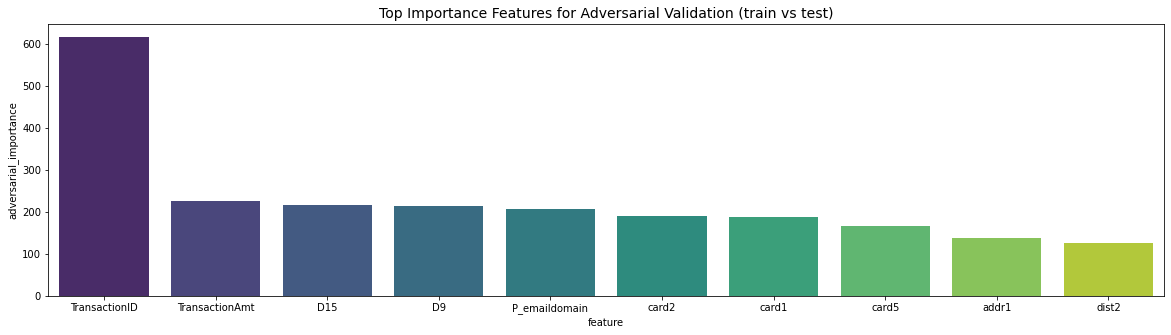

In [143]:
importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

In [144]:
importance["feature"].values

array(['TransactionID', 'TransactionAmt', 'D15', 'D9', 'P_emaildomain',
       'card2', 'card1', 'card5', 'addr1', 'dist2'], dtype=object)

In [145]:
features = ['TransactionID', 'TransactionAmt', 'D15', 'D9', 
       'card2', 'card1', 'card5', 'addr1', 'dist2']

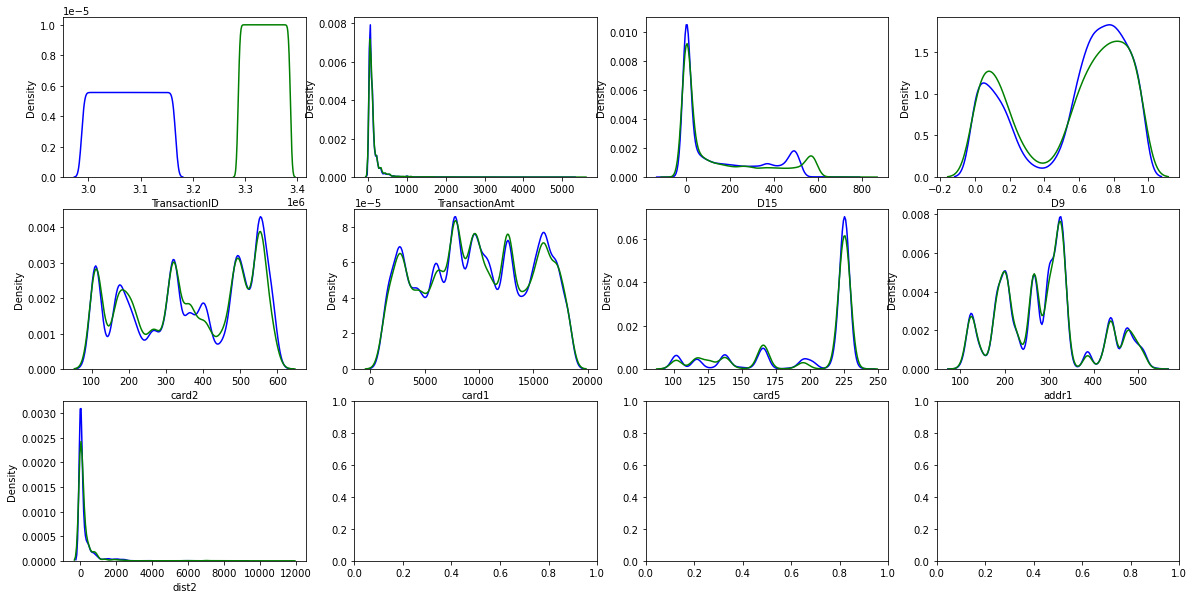

In [146]:
# Посмотрим. какое распределение имеют эти признаки. на графике.
num_cols =4
fig, axes = plt.subplots(3, num_cols, figsize=(20, 10))

for num, feature in enumerate(features):
    try:
        train_data, test_data = public_df[feature].copy(), private_df[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//num_cols, num%num_cols], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//num_cols, num%num_cols], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = public_df[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//num_cols, num%num_cols], color="blue", label="train")
    # axes[num//num_cols, num%num_cols].set_title(feature, fontsize=14)

Уберем из набора данных признаки `TransactionID` и `TransactionDT`. И, посмотрим как это повлияет на результат.

In [147]:
X_adv = pd.concat([ public_df.drop(['TransactionID','TransactionDT'],axis=1), private_df.drop(['TransactionID','TransactionDT'],axis=1)])
y_adv = np.hstack((np.ones(public_df.shape[0]), np.zeros(private_df.shape[0]))) # заполняем чать нулями, а часть 1-ми.

X_adv = X_adv.reset_index(drop=True)
X_adv[categorical]=X_adv[categorical].astype('category')

In [173]:
x_lb = x_lb.drop(['TransactionDT'],axis=1)

Подоберем параметры, которые похожи на данные лидерборда.

In [148]:
def make_validation_df(public_df,private_df,num_features,categorical_feature):
    val_df = public_df.copy()
    
    for feature in num_features:
        min_value = private_df[feature].min()
        max_value = private_df[feature].max()
        val_df = val_df.loc[(val_df[feature]>=min_value)]
        val_df = val_df.loc[(val_df[feature]<=max_value)]

    for feature in categorical_feature:
        categories = private_df[feature].value_counts().index.to_numpy()
        val_df = val_df.loc[(val_df[feature].isin(categories))]
    return val_df

In [149]:
# Соберем тренировочный и тесовый наборы заново.

val_df_1 = make_validation_df(private_df, private_df, features, ['P_emaildomain'])

train_df_1 = public_df.drop(index=val_df_1.index)

In [150]:
len(train_df_1), len(val_df_1)

(179891, 109)

In [151]:
val_df_1[categorical]=val_df_1[categorical].astype('category')
train_df_1[categorical]=train_df_1[categorical].astype('category')

In [165]:
x_val_1 = val_df_1.drop(["TransactionID",'TransactionDT', "isFraud"], axis=1)
y_val_1 = val_df_1["isFraud"].values

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(train_df_1.drop(["TransactionID",'TransactionDT', "isFraud"], axis=1),train_df_1["isFraud"], train_size=0.7,shuffle=True)

In [ ]:
# x_train_1 = train_df_1.drop(["TransactionID",'TransactionDT', "isFraud"], axis=1)
# y_train_1 = train_df_1["isFraud"]

In [153]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    # "objective": "binary:logistic",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 50,
    "max_depth": 4,
    # "gamma": 4,
    # "nthread": 6,
    # "seed": 27,
    'random_state':1    
}

In [154]:
model = lgb.LGBMClassifier(**params)

In [159]:
model.fit(
    X=x_train_1,
    y=y_train_1,
    eval_set=[(x_train_1, y_train_1),(x_test_1, y_test_1) ],
    early_stopping_rounds=50,
    categorical_feature=categorical,
    # num_boost_round=100,
    eval_metric="auc",
    verbose=10
)

[10]	training's auc: 0.868177	valid_1's auc: 0.870868
[20]	training's auc: 0.880629	valid_1's auc: 0.882281
[30]	training's auc: 0.889172	valid_1's auc: 0.890592
[40]	training's auc: 0.894552	valid_1's auc: 0.895923
[50]	training's auc: 0.898898	valid_1's auc: 0.899767
[60]	training's auc: 0.901509	valid_1's auc: 0.901741
[70]	training's auc: 0.904821	valid_1's auc: 0.903991
[80]	training's auc: 0.907752	valid_1's auc: 0.905976
[90]	training's auc: 0.909443	valid_1's auc: 0.907174
[100]	training's auc: 0.911736	valid_1's auc: 0.908881
[110]	training's auc: 0.9132	valid_1's auc: 0.909928
[120]	training's auc: 0.91466	valid_1's auc: 0.911154
[130]	training's auc: 0.916625	valid_1's auc: 0.912838
[140]	training's auc: 0.918151	valid_1's auc: 0.913919
[150]	training's auc: 0.919775	valid_1's auc: 0.915074
[160]	training's auc: 0.921685	valid_1's auc: 0.916431
[170]	training's auc: 0.923052	valid_1's auc: 0.917183
[180]	training's auc: 0.92438	valid_1's auc: 0.918001
[190]	training's auc: 0

LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

In [175]:
train_score =  roc_auc_score(y_train_1, model.predict(x_train_1))
test_score = roc_auc_score(y_test_1, model.predict(x_test_1))
# val_score = roc_auc_score(y_val_1, model.predict(x_val_1))
lb_score = roc_auc_score(y_lb, model.predict(x_lb))
# print(f"Val-score: {round(val_score, 3)}, Lb-score: {round(lb_score, 3)} ")

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}, LB-score: {round(lb_score, 3)}")

Train-score: 0.815, Test-score: 0.817, LB-score: 0.64


In [177]:
train_score =  f1_score(y_train_1, model.predict(x_train_1))
test_score =  f1_score(y_test_1, model.predict(x_test_1))
val_score = f1_score(y_val_1, model.predict(x_val_1))
lb_score = f1_score(y_lb, model.predict(x_lb))

print(f"Val-score: {round(val_score, 3)}, Lb-score: {round(lb_score, 3)} ")
print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Val-score: 0.0, Lb-score: 0.423 
Train-score: 0.763, Test-score: 0.767


In [ ]:
Далее необходимо подобрать параметры, которые похожи на данные лидерборда.

In [ ]:
видно что объекты содержт выбросы. ==> их необходимо почистить. убрать лишние и обрезать. 

## Задание 5.

Сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.


In [178]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [179]:
cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
   x_lb, y_lb, model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 80000, valid-observations = 20001
train-score = 0.9637, valid-score = 0.8134
Fold: 2, train-observations = 80001, valid-observations = 20000
train-score = 0.965, valid-score = 0.8202
Fold: 3, train-observations = 80001, valid-observations = 20000
train-score = 0.9592, valid-score = 0.8173
Fold: 4, train-observations = 80001, valid-observations = 20000
train-score = 0.9621, valid-score = 0.8192
Fold: 5, train-observations = 80001, valid-observations = 20000
train-score = 0.9627, valid-score = 0.8146
CV-results train: 0.9626 +/- 0.002
CV-results valid: 0.817 +/- 0.003
OOF-score = 0.817


In [180]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
   x_lb, y_lb, model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 80000, valid-observations = 20001
train-score = 0.9647, valid-score = 0.8114
Fold: 2, train-observations = 80001, valid-observations = 20000
train-score = 0.9638, valid-score = 0.8313
Fold: 3, train-observations = 80001, valid-observations = 20000
train-score = 0.962, valid-score = 0.8218
Fold: 4, train-observations = 80001, valid-observations = 20000
train-score = 0.9633, valid-score = 0.8199
Fold: 5, train-observations = 80001, valid-observations = 20000
train-score = 0.964, valid-score = 0.8062
CV-results train: 0.9636 +/- 0.001
CV-results valid: 0.8181 +/- 0.009
OOF-score = 0.8181


## Задание 6 (опциональное).

Сделать Hold-Out валидацию по времени (`TransactionDT`), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.


## Задание 7 (совсем опциональное).

В данном наборе данных у нас есть ID-транзакции (`TransactionID`) и время транзакции (`TransactionDT`), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (`GroupKFold`).